In [27]:
import numpy as np
import matplotlib.pyplot as plt

from make_boxplots import load_data
from prettytable import PrettyTable

In [49]:
data_trained = load_data('output/mos_items/')
data_untrained = load_data('output/untrained_mos_items/')

In [50]:
metrics = ['pesq', 'warpq', 'moc', 'nomad']
bitrates = [6000, 7500, 9000, 12000, 15000, 18000, 24000, 32000]


means = dict()

for metric in metrics:
    print(metric)
    means[metric] = dict()
    dt = data_trained[metric]
    du = data_untrained[metric]
    
    means[metric]['opus'] = np.zeros(len(bitrates))
    means[metric]['lace'] = np.zeros((len(bitrates), 2))
    means[metric]['nolace'] = np.zeros((len(bitrates), 2))
    
    for i, br in enumerate(bitrates):
        opus = np.mean(dt[br][:, 0])
        lace_t = np.mean(dt[br][:, 1])
        lace_u = np.mean(du[br][:, 1])
        nolace_t = np.mean(dt[br][:, 2])
        nolace_u = np.mean(du[br][:, 2])
        
        lace_lower = 100 * (lace_u / opus - 1)
        lace_upper = 100 * (lace_t / opus - 1)
        nolace_lower = 100 * (nolace_u / opus - 1)
        nolace_upper = 100 * (nolace_t / opus - 1)
        
        means[metric]['opus'][i] = opus
        means[metric]['lace'][i, 0] = lace_u
        means[metric]['lace'][i, 1] = lace_t
        means[metric]['nolace'][i, 0] = nolace_u
        means[metric]['nolace'][i, 1] = nolace_t
        
        print(f"{br} {lace_lower} {lace_upper} {nolace_lower} {nolace_upper}")
        
        


pesq
6000 -13.993122117348278 39.49586296300418 7.280307594693136 43.46997108590143
7500 -23.961186736735186 20.890645128611453 -5.589590544559986 20.113705266950177
9000 -30.092781649911004 8.361685027678977 -17.139510184205232 6.557062525877133
12000 -34.313493271068694 2.903560727621324 -24.85287158434787 1.7389699671776393
15000 -34.577764454679105 1.6134120575314492 -27.556124439982 0.4285718225490731
18000 -34.79414129235599 0.8275867765733302 -28.859814443263787 -0.4952826006281996
24000 -37.605647294726516 0.2657920821966586 -29.570049631735827 -1.3011832449216887
32000 -39.879880033882046 -0.07919488579778422 -30.799031852116265 -1.988195943824922
warpq
6000 6.077654848351921 -7.219277785773837 8.644007957260037 -14.042869780463441
7500 10.563535964237825 -4.822754711959765 16.30352295670654 -8.057236041623373
9000 15.9745185918853 -3.330685324222804 25.316909029146807 -4.487252782416551
12000 25.966450501541782 -1.5782331895615287 42.56520287957066 -1.0232371819566377
15000 3

In [51]:
signs = dict(pesq=1, warpq=-1, moc=-1, moc2=-1, nomad=-1)
thresholds = dict()


for metric in metrics:

    lace_pass = 100 * (means[metric]['lace'][:, 1] / means[metric]['opus'] - 1)
    nolace_pass = 100 * (means[metric]['nolace'][:, 1] / means[metric]['opus'] - 1)

    lace_fail = 100 * (means[metric]['lace'][:, 0] / means[metric]['opus'] - 1)
    nolace_fail = 100 * (means[metric]['nolace'][:, 0] / means[metric]['opus'] - 1)

    if signs[metric] < 0:
        fail_threshold = np.minimum(lace_fail, nolace_fail)
        pass_threshold = np.maximum(lace_pass, nolace_pass)
    else:
        fail_threshold = np.maximum(lace_fail, nolace_fail)
        pass_threshold = np.minimum(lace_pass, nolace_pass)
    
    thresholds[metric] = dict(good=pass_threshold, bad=fail_threshold)
    


In [52]:
invert = True
if invert:
    signs = dict(pesq=1, warpq=-1, moc=-1, moc2=-1, nomad=-1)
    thresholds = dict()


    for metric in metrics:

        if metric != 'pesq':
            lace_pass = 100 * (means[metric]['lace'][:, 1] / means[metric]['opus'] - 1)
            nolace_pass = 100 * (means[metric]['nolace'][:, 1] / means[metric]['opus'] - 1)

            lace_fail = 100 * (means[metric]['lace'][:, 0] / means[metric]['opus'] - 1)
            nolace_fail = 100 * (means[metric]['nolace'][:, 0] / means[metric]['opus'] - 1)

        else:
            offset = 0
            lace_pass = 100 * ((1/means[metric]['lace'][:, 1] - offset) / (1/means[metric]['opus'] - offset) - 1)
            nolace_pass = 100 * ((1/means[metric]['nolace'][:, 1] - offset) / (1/means[metric]['opus'] - offset) - 1)
            lace_fail = 100 * ((1/means[metric]['lace'][:, 0] - offset) / (1/means[metric]['opus'] - offset) - 1)
            nolace_fail = 100 * ((1/means[metric]['nolace'][:, 0] - offset) / (1/means[metric]['opus'] - offset) - 1)
            
            

        fail_threshold = np.minimum(lace_fail, nolace_fail)
        pass_threshold = np.maximum(lace_pass, nolace_pass)

        
        thresholds[metric] = dict(good=pass_threshold, bad=fail_threshold)

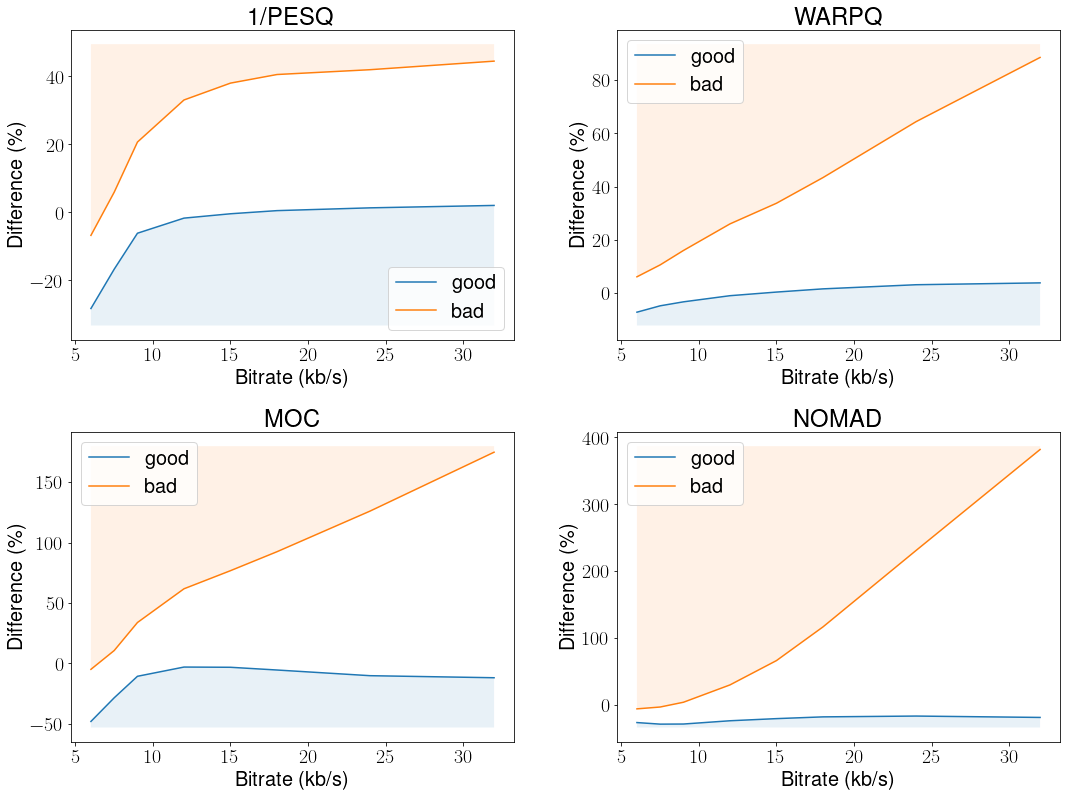

In [53]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 20
})

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16, 12)
fig.tight_layout(pad=3)

x = [br/1000 for br in bitrates]

axs[0, 0].plot(x, thresholds['pesq']['good'], label='good')
axs[0, 0].plot(x, thresholds['pesq']['bad'], label='bad')
if invert:
    axs[0, 0].fill_between(x, thresholds['pesq']['good'], y2=thresholds['pesq']['good'].min() - 5, alpha=0.1)
    axs[0, 0].fill_between(x, thresholds['pesq']['bad'], y2=thresholds['pesq']['bad'].max() + 5, alpha=0.1)
    axs[0, 0].set_title('1/PESQ')
else:
    axs[0, 0].fill_between(x, thresholds['pesq']['good'], y2=thresholds['pesq']['good'].max() + 5, alpha=0.1)
    axs[0, 0].fill_between(x, thresholds['pesq']['bad'], y2=thresholds['pesq']['bad'].min() - 5, alpha=0.1)
    axs[0, 0].set_title('PESQ')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Bitrate (kb/s)')
axs[0, 0].set_ylabel('Difference (\%)')



axs[0, 1].plot(x, thresholds['warpq']['good'], label='good')
axs[0, 1].plot(x, thresholds['warpq']['bad'], label='bad')
axs[0, 1].fill_between(x, thresholds['warpq']['good'], y2=thresholds['warpq']['good'].min() - 5, alpha=0.1)
axs[0, 1].fill_between(x, thresholds['warpq']['bad'], y2=thresholds['warpq']['bad'].max() + 5, alpha=0.1)
axs[0, 1].set_title('WARPQ')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Bitrate (kb/s)')
axs[0, 1].set_ylabel('Difference (\%)')


axs[1, 0].plot(x, thresholds['moc']['good'], label='good')
axs[1, 0].plot(x, thresholds['moc']['bad'], label='bad')
axs[1, 0].fill_between(x, thresholds['moc']['good'], y2=thresholds['moc']['good'].min() - 5, alpha=0.1)
axs[1, 0].fill_between(x, thresholds['moc']['bad'], y2=thresholds['moc']['bad'].max() + 5, alpha=0.1)
axs[1, 0].set_title('MOC')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Bitrate (kb/s)')
axs[1, 0].set_ylabel('Difference (\%)')

axs[1, 1].plot(x, thresholds['nomad']['good'], label='good')
axs[1, 1].plot(x, thresholds['nomad']['bad'], label='bad')
axs[1, 1].fill_between(x, thresholds['nomad']['good'], y2=thresholds['nomad']['good'].min() - 5, alpha=0.1)
axs[1, 1].fill_between(x, thresholds['nomad']['bad'], y2=thresholds['nomad']['bad'].max() + 5, alpha=0.1)
axs[1, 1].set_title('NOMAD')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Bitrate (kb/s)')
axs[1, 1].set_ylabel('Difference (\%)')

fig.savefig('pass_fail_thresholds.png')

In [45]:
tbl = PrettyTable()

tbl.field_names = ['Bitrate', 'PESQ', 'WARP-Q', 'MOC', 'NOMAD']
for i, br in enumerate(bitrates):
    if invert:
        tbl.add_row([br, f"< {thresholds['pesq']['good'][i]+0.025:.2f} %", f"< {thresholds['warpq']['good'][i] + 0.025:.2f} %", f"< {thresholds['moc']['good'][i] + 0.025:.2f} %", f"< {thresholds['nomad']['good'][i] + 0.025:.2f} %"])
    else:
        tbl.add_row([br, f"> {thresholds['pesq']['good'][i]-0.1:.2f} %", f"< {thresholds['warpq']['good'][i] + 0.025:.2f} %", f"< {thresholds['moc']['good'][i] + 0.025:.2f} %", f"< {thresholds['nomad']['good'][i] + 0.025:.2f} %"])
    
with open('thresholds.csv', 'w') as f:
    f.write(tbl.get_csv_string())


In [46]:
print(tbl)

+---------+------------+-----------+------------+------------+
| Bitrate |    PESQ    |   WARP-Q  |    MOC     |   NOMAD    |
+---------+------------+-----------+------------+------------+
|   6000  | < -15.84 % | < -6.76 % | < -37.11 % | < -39.64 % |
|   7500  | < -5.82 %  | < -3.01 % | < -11.07 % | < -30.66 % |
|   9000  |  < 0.57 %  | < -0.89 % | < -1.78 %  | < -26.26 % |
|  12000  |  < 4.59 %  |  < 0.59 % | < -1.02 %  | < -12.50 % |
|  15000  |  < 5.28 %  |  < 1.05 % | < -2.88 %  | < -4.59 %  |
|  18000  |  < 5.05 %  |  < 1.29 % | < -4.83 %  | < -5.91 %  |
|  24000  |  < 4.28 %  |  < 1.57 % | < -7.15 %  | < -5.90 %  |
|  32000  |  < 3.83 %  |  < 1.35 % | < -7.39 %  | < -1.79 %  |
+---------+------------+-----------+------------+------------+


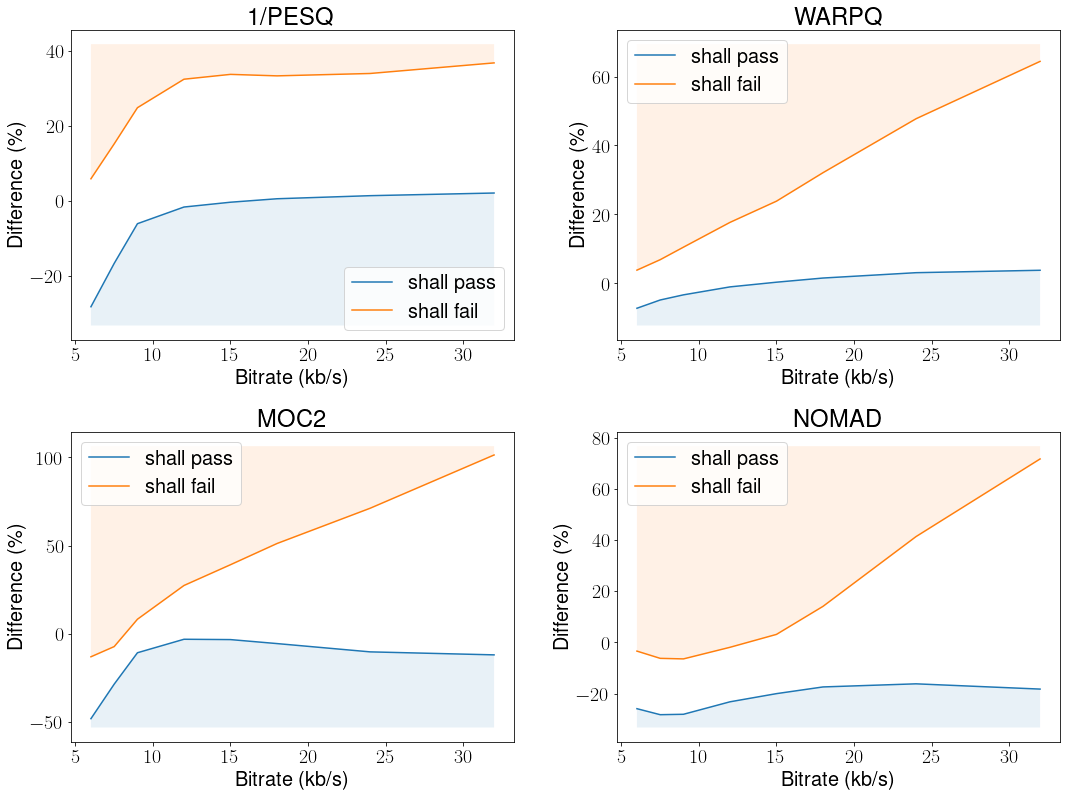

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 20
})

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16, 12)
fig.tight_layout(pad=3)

x = [br/1000 for br in bitrates]

axs[0, 0].plot(x, thresholds['pesq']['good'], label='good')
axs[0, 0].plot(x, thresholds['pesq']['bad'], label='bad')
if invert:
    axs[0, 0].fill_between(x, thresholds['pesq']['good'], y2=thresholds['pesq']['good'].min() - 5, alpha=0.1)
    axs[0, 0].fill_between(x, thresholds['pesq']['bad'], y2=thresholds['pesq']['bad'].max() + 5, alpha=0.1)
    axs[0, 0].set_title('1/PESQ')
else:
    axs[0, 0].fill_between(x, thresholds['pesq']['good'], y2=thresholds['pesq']['good'].max() + 5, alpha=0.1)
    axs[0, 0].fill_between(x, thresholds['pesq']['bad'], y2=thresholds['pesq']['bad'].min() - 5, alpha=0.1)
    axs[0, 0].set_title('PESQ')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Bitrate (kb/s)')
axs[0, 0].set_ylabel('Difference (\%)')



axs[0, 1].plot(x, thresholds['warpq']['good'], label='good')
axs[0, 1].plot(x, thresholds['warpq']['bad'], label='bad')
axs[0, 1].fill_between(x, thresholds['warpq']['good'], y2=thresholds['warpq']['good'].min() - 5, alpha=0.1)
axs[0, 1].fill_between(x, thresholds['warpq']['bad'], y2=thresholds['warpq']['bad'].max() + 5, alpha=0.1)
axs[0, 1].set_title('WARPQ')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Bitrate (kb/s)')
axs[0, 1].set_ylabel('Difference (\%)')


axs[1, 0].plot(x, thresholds['moc2']['good'], label='good')
axs[1, 0].plot(x, thresholds['moc2']['bad'], label='bad')
axs[1, 0].fill_between(x, thresholds['moc2']['good'], y2=thresholds['moc2']['good'].min() - 5, alpha=0.1)
axs[1, 0].fill_between(x, thresholds['moc2']['bad'], y2=thresholds['moc2']['bad'].max() + 5, alpha=0.1)
axs[1, 0].set_title('MOC2')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Bitrate (kb/s)')
axs[1, 0].set_ylabel('Difference (\%)')

axs[1, 1].plot(x, thresholds['nomad']['good'], label='good')
axs[1, 1].plot(x, thresholds['nomad']['bad'], label='bad')
axs[1, 1].fill_between(x, thresholds['nomad']['good'], y2=thresholds['nomad']['good'].min() - 5, alpha=0.1)
axs[1, 1].fill_between(x, thresholds['nomad']['bad'], y2=thresholds['nomad']['bad'].max() + 5, alpha=0.1)
axs[1, 1].set_title('NOMAD')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Bitrate (kb/s)')
axs[1, 1].set_ylabel('Difference (\%)')

fig.savefig('pass_fail_thresholds_moc2.png')

In [10]:
tbl = PrettyTable()
if invert:
    tbl.field_names = ['Bitrate', '1/PESQ', 'WARP-Q', 'MOC2', 'NOMAD']
else:
    tbl.field_names = ['Bitrate', 'PESQ', 'WARP-Q', 'MOC2', 'NOMAD']
for i, br in enumerate(bitrates):
    if invert:
        tbl.add_row([br, f"< {thresholds['pesq']['good'][i]-0.1:.2f} %", f"< {thresholds['warpq']['good'][i] + 0.025:.2f} %", f"< {thresholds['moc2']['good'][i] + 0.025:.2f} %", f"< {thresholds['nomad']['good'][i] + 0.025:.2f} %"])
    else:
        tbl.add_row([br, f"> {thresholds['pesq']['good'][i]-0.1:.2f} %", f"< {thresholds['warpq']['good'][i] + 0.025:.2f} %", f"< {thresholds['moc2']['good'][i] + 0.025:.2f} %", f"< {thresholds['nomad']['good'][i] + 0.025:.2f} %"])
    
with open('thresholds_moc2.csv', 'w') as f:
    f.write(tbl.get_csv_string())

In [11]:
print(tbl)

+---------+------------+-----------+------------+------------+
| Bitrate |   1/PESQ   |   WARP-Q  |    MOC2    |   NOMAD    |
+---------+------------+-----------+------------+------------+
|   6000  | < -28.41 % | < -7.19 % | < -48.05 % | < -25.91 % |
|   7500  | < -16.85 % | < -4.80 % | < -28.49 % | < -28.25 % |
|   9000  | < -6.25 %  | < -3.31 % | < -10.69 % | < -28.09 % |
|  12000  | < -1.81 %  | < -1.00 % | < -3.05 %  | < -23.22 % |
|  15000  | < -0.53 %  |  < 0.37 % | < -3.23 %  | < -20.02 % |
|  18000  |  < 0.40 %  |  < 1.57 % | < -5.49 %  | < -17.41 % |
|  24000  |  < 1.22 %  |  < 3.12 % | < -10.19 % | < -16.19 % |
|  32000  |  < 1.93 %  |  < 3.82 % | < -11.89 % | < -18.25 % |
+---------+------------+-----------+------------+------------+


In [12]:
tbl = PrettyTable()
if invert:
    tbl.field_names = ['Bitrate', '1/PESQ', 'WARP-Q', 'MOC2', 'NOMAD']
else:
    tbl.field_names = ['Bitrate', 'PESQ', 'WARP-Q', 'MOC2', 'NOMAD']
for i, br in enumerate(bitrates):
    if invert:
        tbl.add_row([br, f"< {thresholds['pesq']['bad'][i]-0.1:.2f} %", f"< {thresholds['warpq']['bad'][i] - 0.025:.2f} %", f"< {thresholds['moc2']['bad'][i] - 0.025:.2f} %", f"< {thresholds['nomad']['bad'][i] - 0.025:.2f} %"])
    else:
        tbl.add_row([br, f"> {thresholds['pesq']['bad'][i]-0.1:.2f} %", f"< {thresholds['warpq']['bad'][i] - 0.025:.2f} %", f"< {thresholds['moc2']['bad'][i] - 0.025:.2f} %", f"< {thresholds['nomad']['bad'][i] - 0.025:.2f} %"])
    
with open('thresholds_moc2.csv', 'w') as f:
    f.write(tbl.get_csv_string())

In [13]:
print(tbl)

+---------+-----------+-----------+------------+-----------+
| Bitrate |   1/PESQ  |   WARP-Q  |    MOC2    |   NOMAD   |
+---------+-----------+-----------+------------+-----------+
|   6000  |  < 5.73 % |  < 3.81 % | < -13.02 % | < -3.45 % |
|   7500  | < 15.04 % |  < 6.84 % | < -7.25 %  | < -6.28 % |
|   9000  | < 24.69 % | < 10.48 % |  < 8.26 %  | < -6.50 % |
|  12000  | < 32.29 % | < 17.67 % | < 27.38 %  | < -1.97 % |
|  15000  | < 33.58 % | < 23.82 % | < 39.16 %  |  < 3.08 % |
|  18000  | < 33.19 % | < 32.08 % | < 51.17 %  | < 14.04 % |
|  24000  | < 33.82 % | < 47.73 % | < 71.15 %  | < 41.31 % |
|  32000  | < 36.65 % | < 64.38 % | < 101.36 % | < 71.65 % |
+---------+-----------+-----------+------------+-----------+
